In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models,layers

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

**Import data set**

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/MyDrive/Potato/Train",
    seed=123,
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 900 files belonging to 3 classes.


In [8]:
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/MyDrive/Potato/Test",
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 300 files belonging to 3 classes.


In [9]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/MyDrive/Potato/Valid",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 300 files belonging to 3 classes.


In [14]:
300/32,900/32,300/32

(9.375, 28.125, 9.375)

In [13]:
len(val_dataset),len(test_dataset),len(dataset)

(10, 10, 29)

So dataset yields tuples (images, labels) when you iterate over it.

images → A batch of images, shape = (batch_size, height, width, channels)

labels → A batch of corresponding labels, shape = (batch_size,)

In [19]:
for batch_size,label_size in dataset.take(2): #.take(1) only take one batch
  print("image_shape",batch_size.shape)
  print("label",label_size.numpy)

image_shape (32, 255, 255, 3)
label <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 1, 2, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 1, 2, 1, 1], dtype=int32)>>
image_shape (32, 255, 255, 3)
label <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 2, 2, 2, 1, 2, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2,
       0, 1, 2, 1, 2, 2, 1, 2, 2, 0], dtype=int32)>>


**Visulize Image**

In [23]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

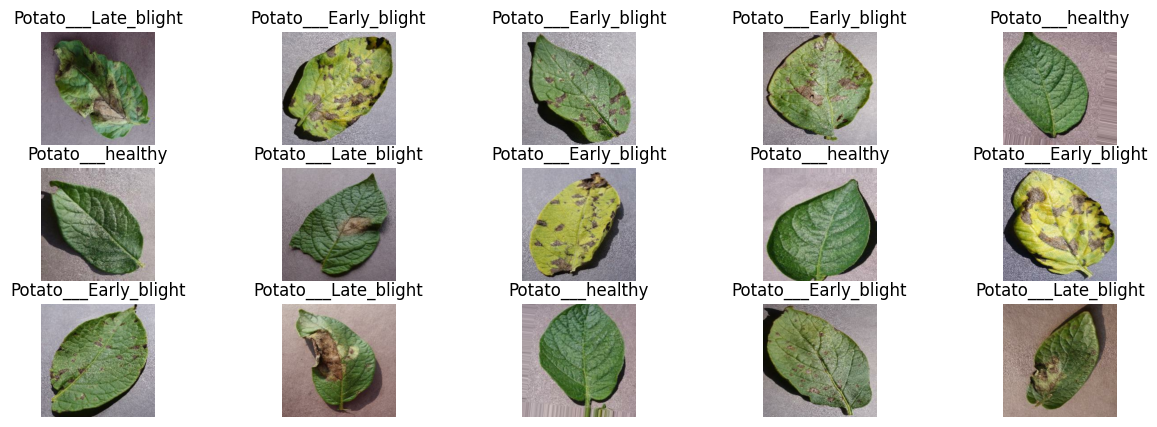

In [27]:
plt.figure(figsize=(15,5))
for image,label in dataset.take(1):
  for i in range(15):
    ax=plt.subplot(3,5,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")
  plt.show()

**Cache,Shuffle,Prefetch**

In [29]:
dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

**Model**

Data Agumentation

In [32]:
data_agumentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    ])

In [33]:
dataset=dataset.map(
    lambda x,y: (data_agumentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model_Arcitecture

In [41]:

n_classes = 3

resize_rescaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)), # Explicitly define the input layer
    resize_rescaling,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
], name="my_model")

model.build()
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

complie and fit the model

In [42]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [43]:
history = model.fit(
    dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=20,
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.4172 - loss: 1.0866 - val_accuracy: 0.4567 - val_loss: 1.0519
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.6171 - loss: 0.7737 - val_accuracy: 0.6300 - val_loss: 0.8441
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.6988 - loss: 0.6482 - val_accuracy: 0.7300 - val_loss: 0.5640
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - accuracy: 0.7285 - loss: 0.5558 - val_accuracy: 0.8000 - val_loss: 0.4685
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7524 - loss: 0.5139 - val_accuracy: 0.8133 - val_loss: 0.4026
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.8463 - loss: 0.3877 - val_accuracy: 0.8600 - val_loss: 0.2932
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.8828 - loss: 0.2986 - val_accuracy: 0.8800 - val_loss: 0.2929
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.9106 - loss: 0.2794 - val_accura

In [44]:
model.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.9115 - loss: 0.1873


[0.17147187888622284, 0.9300000071525574]

In [46]:
model.save('model.h5')

**Plotting accuracy and loss graph**

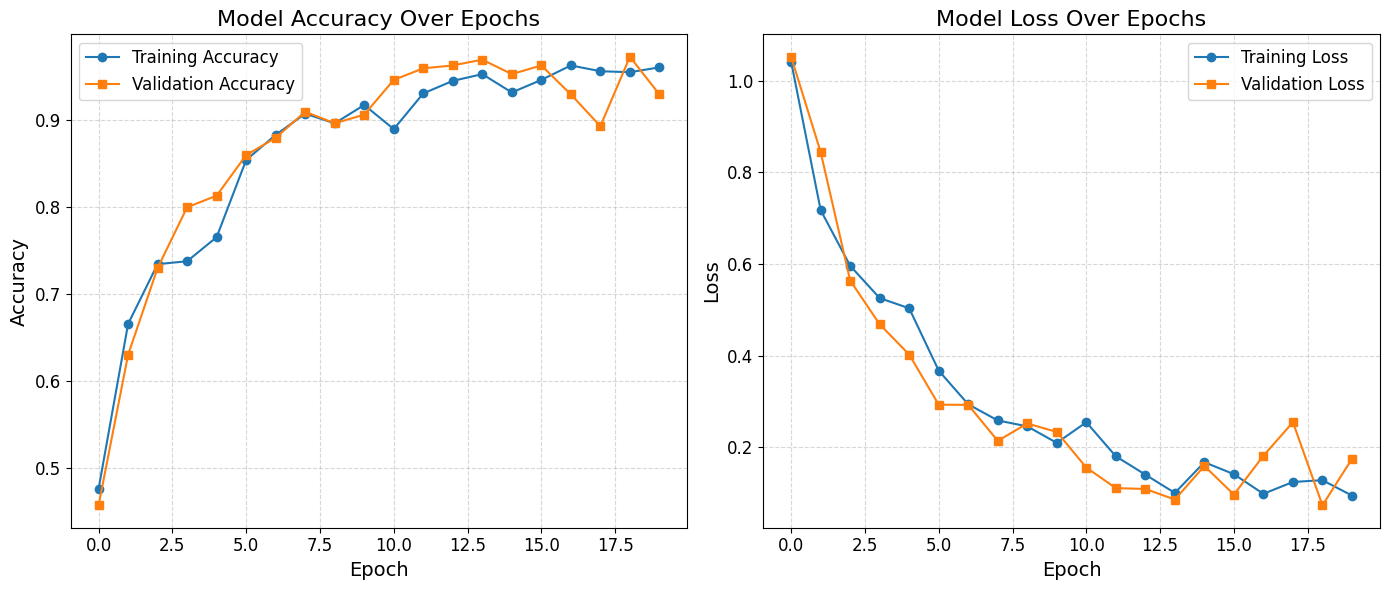

In [50]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots
plt.figure(figsize=(14,6))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


**Prediction image**

In [51]:
model=tf.keras.models.load_model("model.h5")

actual lavel :  Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
predicted_label : Potato___healthy


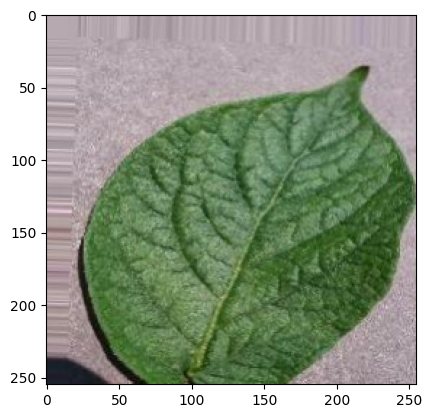

In [84]:
for image_batch,label in test_dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  print("actual lavel : ",class_names[label[0]])

  batch_prediction=model.predict(image_batch)
  print("predicted_label :",class_names[np.argmax(batch_prediction[0])])

In [75]:
from tensorflow.keras.utils import img_to_array
def predict(model,img):
  img_array=img_to_array(img)
  img_array=tf.expand_dims(img_array,0)

  prediction=model.predict(img_array)
  print(prediction)
  prediction_class=class_names[np.argmax(prediction[0])]
  prediction_confidence=round(100 * (np.max(prediction[0])), 2)
  return prediction_class,prediction_confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[2.6015822e-14 9.9407873e-05 9.9990058e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[9.9996459e-01 3.5366771e-05 2.1945968e-11]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[1.8106765e-15 1.1320267e-05 9.9998868e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[3.480465e-04 9.996519e-01 3.456070e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[3.9569616e-01 6.0430312e-01 7.4040253e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[4.4650238e-12 1.3403780e-02 9.8659617e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[1.7680317e-14 3.6057932e-05 9.9996400e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[6.345049e-10 8.114545e-04 9.991885e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.00877948 0.98684    0.00438051]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[5.0631864e-03 9.9487782e-01 5.8923761e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[8.89245979e-13 1.19030614e-04 9.99880910e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[6.1925343e-12 7.2165085e-03 9.9278355e-01]]
1/1 

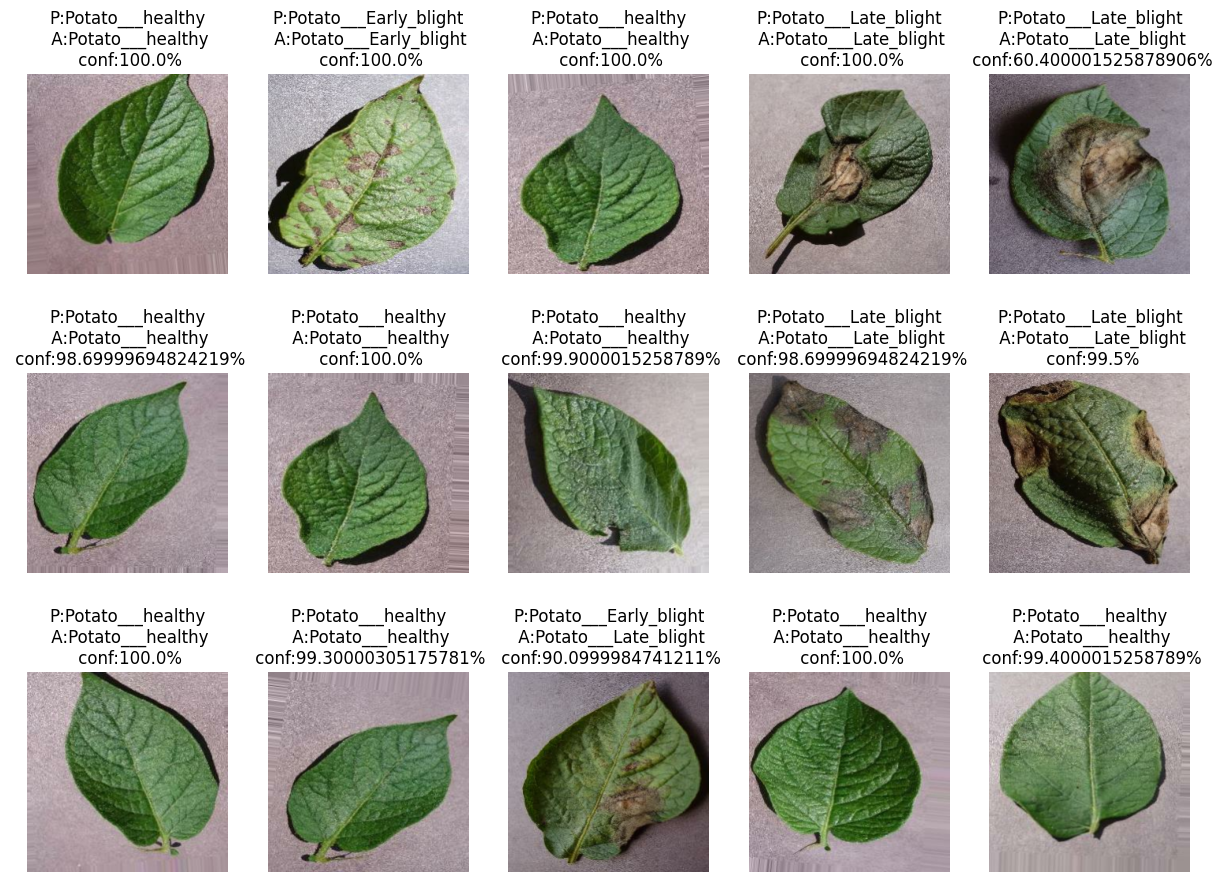

In [81]:
plt.figure(figsize=(15,11))
for image_batch,label in val_dataset.take(1):
  for i in range(15):
    ax=plt.subplot(3,5,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))

    predicted_class,confidence=predict(model,image_batch[i].numpy())
    actual_class=class_names[label[i]]
    plt.title(f"P:{predicted_class}\n A:{actual_class}\n conf:{round(confidence,1)}%")
    plt.axis('off')
  plt.show()